Scatter Plot

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load a pre-trained ResNet152 model
model = torchvision.models.resnet152(pretrained=True)

# Remove the final fully connected layer to get the feature embeddings
model = torch.nn.Sequential(*list(model.children())[:-1])

# Set the model to evaluation mode
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:05<00:00, 47.3MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [3]:
!unzip imagesSRGAN4.zip
!unzip imagescycleGANwithseg.zip

Archive:  imagesSRGAN4.zip
replace imagesSRGAN4/10060_fake.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  imagescycleGANwithseg.zip
replace imagescycleGANwithseg/10060_fake.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  imagescycleganwithoutseg.zip
   creating: imagescycleganwithoutseg/
  inflating: imagescycleganwithoutseg/10060_fake.png  
  inflating: imagescycleganwithoutseg/10060_real.png  
  inflating: imagescycleganwithoutseg/10063_fake.png  
  inflating: imagescycleganwithoutseg/10063_real.png  
  inflating: imagescycleganwithoutseg/10081_fake.png  
  inflating: imagescycleganwithoutseg/10081_real.png  
  inflating: imagescycleganwithoutseg/10096_fake.png  
  inflating: imagescycleganwithoutseg/10096_real.png  
  inflating: imagescycleganwithoutseg/10097_fake.png  
  inflating: imagescycleganwithoutseg/10097_real.png  
  inflating: imagescycleganwithoutseg/10098_fake.png  
  inflating: imagescycleganwithoutseg/10098_real.png  
  inflating: imagescycleganwithoutseg/10

In [4]:
!unzip imagescycleganwithoutseg.zip
!unzip realistic_image.zip

Archive:  imagescycleganwithoutseg.zip
replace imagescycleganwithoutseg/10060_fake.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  realistic_image.zip
replace realistic image/2014-07-22 11_25_08.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
import numpy as np
import os
import shutil
from PIL import Image
from torch.utils.data import DataLoader, Dataset

In [6]:
os.rename('imagesSRGAN4','imagesSRGAN4_real')
os.rename('imagescycleGANwithseg','imagescycleGANwithseg_real')
os.rename('imagescycleganwithoutseg','imagescycleganwithoutseg_real')

In [7]:
!mkdir imagesSRGAN4_fake
!mkdir imagescycleGANwithseg_fake
!mkdir imagescycleganwithoutseg_fake

In [8]:
for root, dirs, files in os.walk(r'imagesSRGAN4_real'):
    # select file name
    for file in files:
        # check the extension of files
        if file.endswith('fake.png'):
            # print whole path of files
            path_image = os.path.join(root, file)
            shutil.move(path_image,'imagesSRGAN4_fake')

In [9]:
for root, dirs, files in os.walk(r'imagescycleGANwithseg_real'):
    # select file name
    for file in files:
        # check the extension of files
        if file.endswith('fake.png'):
            # print whole path of files
            path_image = os.path.join(root, file)
            shutil.move(path_image,'imagescycleGANwithseg_fake')

In [10]:
for root, dirs, files in os.walk(r'imagescycleganwithoutseg_real'):
    # select file name
    for file in files:
        # check the extension of files
        if file.endswith('fake.png'):
            # print whole path of files
            path_image = os.path.join(root, file)
            shutil.move(path_image,'imagescycleganwithoutseg_fake')

In [11]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [12]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_paths = [os.path.join(img_dir, img_name) for img_name in os.listdir(img_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image


In [13]:
dataset_real_srgan = CustomImageDataset(img_dir='imagesSRGAN4_real', transform=transform)
dataloader_real_srgan = DataLoader(dataset_real_srgan, batch_size=64, shuffle=True)

dataset_fake_srgan = CustomImageDataset(img_dir='imagesSRGAN4_fake', transform=transform)
dataloader_fake_srgan = DataLoader(dataset_fake_srgan, batch_size=64, shuffle=True)

In [14]:
dataset_real_cganwith = CustomImageDataset(img_dir='imagescycleGANwithseg_real', transform=transform)
dataloader_real_cganwith = DataLoader(dataset_real_cganwith, batch_size=64, shuffle=True)

dataset_fake_cganwith = CustomImageDataset(img_dir='imagescycleGANwithseg_fake', transform=transform)
dataloader_fake_cganwith = DataLoader(dataset_fake_cganwith, batch_size=64, shuffle=True)

In [15]:
dataset_real_cganwithout = CustomImageDataset(img_dir='imagescycleganwithoutseg_real', transform=transform)
dataloader_real_cganwithout = DataLoader(dataset_real_cganwithout, batch_size=64, shuffle=True)

dataset_fake_cganwithout = CustomImageDataset(img_dir='imagescycleganwithoutseg_fake', transform=transform)
dataloader_fake_cganwithout = DataLoader(dataset_fake_cganwithout, batch_size=64, shuffle=True)

In [16]:
dataset_realistic = CustomImageDataset(img_dir='realistic_image', transform=transform)
dataloader_realistic = DataLoader(dataset_realistic, batch_size=64, shuffle=True)

In [17]:
features_realistic = []

with torch.no_grad():
    for images in dataloader_realistic:
        features_realistic.append(model(images).view(images.size(0), -1).cpu().numpy())


features_realistic = np.concatenate(features_realistic, axis=0)


# Apply t-SNE
tsne = TSNE(n_components=2 , random_state=42)
tsne_features_realistic = tsne.fit_transform(features_realistic)

In [18]:
# Extract features
features_real_srgan = []
features_fake_srgan = []

with torch.no_grad():
    for images in dataloader_real_srgan:
        features_real_srgan.append(model(images).view(images.size(0), -1).cpu().numpy())

with torch.no_grad():
    for images in dataloader_fake_srgan:
        features_fake_srgan.append(model(images).view(images.size(0), -1).cpu().numpy())

features_real_srgan = np.concatenate(features_real_srgan, axis=0)
features_fake_srgan = np.concatenate(features_fake_srgan, axis=0)


# Apply t-SNE
tsne = TSNE(n_components=2 , random_state=42)
tsne_features_real_srgan = tsne.fit_transform(features_real_srgan)
tsne_features_fake_srgan = tsne.fit_transform(features_fake_srgan)

In [19]:
# Extract features
features_real_cganwith = []
features_fake_cganwith = []

with torch.no_grad():
    for images in dataloader_real_cganwith:
        features_real_cganwith.append(model(images).view(images.size(0), -1).cpu().numpy())

with torch.no_grad():
    for images in dataloader_fake_cganwith:
        features_fake_cganwith.append(model(images).view(images.size(0), -1).cpu().numpy())

features_real_cganwith = np.concatenate(features_real_cganwith, axis=0)
features_fake_cganwith = np.concatenate(features_fake_cganwith, axis=0)


# Apply t-SNE
tsne = TSNE(n_components=2 , random_state=42)
tsne_features_real_cganwith = tsne.fit_transform(features_real_cganwith)
tsne_features_fake_cganwith = tsne.fit_transform(features_fake_cganwith)

In [21]:
features_real_cganwithout = []
features_fake_cganwithout = []

with torch.no_grad():
    for images in dataloader_real_cganwithout:
        features_real_cganwithout.append(model(images).view(images.size(0), -1).cpu().numpy())

with torch.no_grad():
    for images in dataloader_fake_cganwithout:
        features_fake_cganwithout.append(model(images).view(images.size(0), -1).cpu().numpy())

features_real_cganwithout = np.concatenate(features_real_cganwithout, axis=0)
features_fake_cganwithout = np.concatenate(features_fake_cganwithout, axis=0)


# Apply t-SNE
tsne = TSNE(n_components=2 , random_state=42)
tsne_features_real_cganwithout = tsne.fit_transform(features_real_cganwithout)
tsne_features_fake_cganwithout = tsne.fit_transform(features_fake_cganwithout)

In [22]:
tsne_features_realistic

array([[ 3.9305768 ,  1.3154441 ],
       [-3.789154  , -1.8487196 ],
       [ 0.32611474, -1.2934704 ],
       [ 0.22171308,  5.250953  ],
       [ 1.5887682 ,  4.477917  ],
       [ 2.0561855 ,  5.45605   ],
       [-1.402423  ,  5.113342  ],
       [ 0.45286724, -1.8996063 ],
       [-0.689012  ,  4.732443  ],
       [-2.3040526 ,  3.2706223 ],
       [-1.6134691 , -4.7009554 ],
       [-0.29504222, -2.0373003 ],
       [-4.2100973 ,  0.46386656],
       [ 4.709238  ,  2.5531566 ],
       [-0.51748985, -1.9736397 ],
       [-0.48629385,  3.147881  ],
       [-2.5135248 ,  1.0332543 ],
       [ 0.8600934 , -0.9267577 ],
       [ 3.4374797 , -0.36648571],
       [ 3.1510637 , -3.029364  ],
       [ 1.5559032 , -1.2219138 ],
       [-0.3201042 , -0.9033011 ],
       [-1.1122742 ,  2.7899742 ],
       [-2.7755988 , -4.297035  ],
       [ 4.0218706 , -1.5316366 ],
       [ 1.938678  ,  0.65482795],
       [ 0.11232506, -3.0305133 ],
       [ 2.1254032 ,  0.79044336],
       [ 0.37311426,

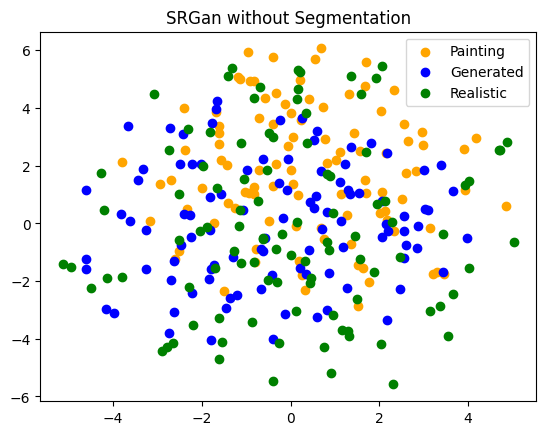

In [25]:
plt.title('SRGan without Segmentation')
plt.scatter(tsne_features_real_srgan[:, 0], tsne_features_real_srgan[:, 1], c='orange', label='Painting')
plt.scatter(tsne_features_fake_srgan[:, 0], tsne_features_fake_srgan[:, 1], c='blue', label='Generated')
plt.scatter(tsne_features_realistic[:, 0], tsne_features_realistic[:, 1], c='green', label='Realistic')
plt.legend()
plt.show()

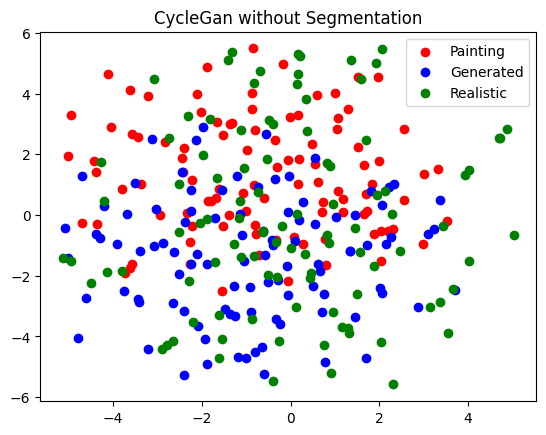

In [26]:
plt.title('CycleGan without Segmentation')
plt.scatter(tsne_features_real_cganwithout[:, 0], tsne_features_real_cganwithout[:, 1], c='red', label='Painting')
plt.scatter(tsne_features_fake_cganwithout[:, 0], tsne_features_fake_cganwithout[:, 1], c='blue', label='Generated')
plt.scatter(tsne_features_realistic[:, 0], tsne_features_realistic[:, 1], c='green', label='Realistic')
plt.legend()
plt.show()

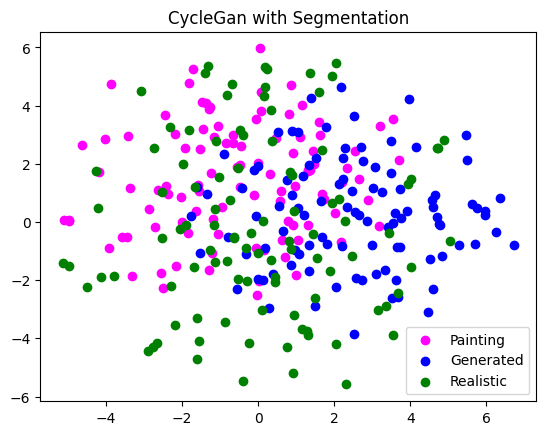

In [29]:
plt.title('CycleGan with Segmentation')
plt.scatter(tsne_features_real_cganwith[:, 0], tsne_features_real_cganwith[:, 1], c='magenta', label='Painting')
plt.scatter(tsne_features_fake_cganwith[:, 0], tsne_features_fake_cganwith[:, 1], c='blue', label='Generated')
plt.scatter(tsne_features_realistic[:, 0], tsne_features_realistic[:, 1], c='green', label='Realistic')
plt.legend()
plt.show()